# Software Setup

* Jbolo: https://github.com/kmharrington/jbolo
* so-bolocalc-model, lat-v3r8 branch: https://github.com/simonsobs/bolocalc-so-model/pull/7  

In [1]:
%matplotlib inline

import os
import yaml
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const

import jbolo.jbolo_funcs as jf
from jbolo.utils import load_sim
import jbolo.utils as utils

import dill as pk

%load_ext autoreload
%autoreload 2

os.environ["JBOLO_PATH"] = "/so/home/jorlo/dev/jbolo"
os.environ["JBOLO_MODELS_PATH"] = "/so/home/jorlo/dev/bolocalc-so-model"

In [2]:
sim_list = {
    'baseline': {
        'LF': os.path.join(os.environ["JBOLO_MODELS_PATH"], "V3r8/V3r8_Baseline/LAT/V3r8_Baseline_LAT_LF.yaml"),
        'MF': os.path.join(os.environ["JBOLO_MODELS_PATH"], "V3r8/V3r8_Baseline/LAT/V3r8_Baseline_LAT_MF.yaml"),
        'UHF': os.path.join(os.environ["JBOLO_MODELS_PATH"], "V3r8/V3r8_Baseline/LAT/V3r8_Baseline_LAT_UHF.yaml"),
    },
    'goal' : {
        'LF': os.path.join(os.environ["JBOLO_MODELS_PATH"], "V3r8/V3r8_Goal/LAT/V3r8_Goal_LAT_LF.yaml"),
        'MF': os.path.join(os.environ["JBOLO_MODELS_PATH"], "V3r8/V3r8_Goal/LAT/V3r8_Goal_LAT_MF.yaml"),
        'UHF': os.path.join(os.environ["JBOLO_MODELS_PATH"], "V3r8/V3r8_Goal/LAT/V3r8_Goal_LAT_UHF.yaml"),
    },
}

n_wafers = {
    'LF_1': 3,
    'LF_2': 3,
    'MF_1': 4*3,
    'MF_2': 4*3,
    'UHF_1': 2*3,
    'UHF_2': 2*3,
}

In [3]:
## example running a single sim and printing some results
sim = load_sim(sim_list['baseline']['MF'])
jf.run_optics(sim)
jf.run_bolos(sim)
jf.print_full_table(sim)

20250423 : V3r8_Baseline_LAT_MF
                             MF_1       MF_2
        det_bandcenter :    93.010    148.009  
         det_bandwidth :    26.930     35.328  
        sys_bandcenter :    92.979    147.962  
         sys_bandwidth :    26.980     35.428  
        sky_bandcenter :    93.056    147.992  
         sky_bandwidth :    26.706     35.250  
optics_effic_total_avg :     0.152      0.377  
        inst_effic_avg :     0.148      0.215  
         effic_tot_avg :     0.143      0.207  
                 P_opt :     1.039      2.223  
                 n_avg :     0.115      0.152  
                P_elec :     2.381      7.147  
                 P_sat :     3.420      9.370  
              loopgain : 10000.000  10000.000  
                F_link :     1.000      1.000  
             G_dynamic :    86.592    237.242  
                  dpdt :     0.043      0.059  
               dpdt_rj :     0.053      0.101  
           NEP_readout :     6.343     10.992  
           

# pW per Kelvin 

We use the `K/pW` numbers in the abs-cal database because those are what we multiply our pW calibration timestreams by to convert them into temperature. But, `pW/K` is the quantity that scales with efficiency.

In [4]:
sim_dict = {}

for flavor in ['MF', 'UHF']:
    sim_dict[flavor] = {}
    for kind in ['baseline', 'goal']:
        sim_dict[flavor][kind] = {}
        print(flavor, kind)
        sim = load_sim(sim_list[kind][flavor])
        jf.run_optics(sim)
        jf.run_bolos(sim)
        for ch in sim['outputs']:
            sim_dict[flavor][kind][ch] = {}
            sim_dict[flavor][kind][ch]["det_eff"] = sim['channels'][ch]['det_eff']
            sim_dict[flavor][kind][ch]["dpdt_rj"] = sim['outputs'][ch]['dpdt_rj']
            print("\t", ch, f"eta={sim['channels'][ch]['det_eff']}  ", 'K_RJ / pW', 1.0/(1e12*sim['outputs'][ch]['dpdt_rj']) )
            
with open("r3v8_sim.pk", "wb") as f:
    pk.dump(sim_dict, f)

MF baseline
	 MF_1 eta=0.974   K_RJ / pW 18.871016107107586
	 MF_2 eta=0.57   K_RJ / pW 9.911860127294345
MF goal
	 MF_1 eta=1.08   K_RJ / pW 14.38473230901672
	 MF_2 eta=0.669   K_RJ / pW 7.624657050421212
UHF baseline
	 UHF_1 eta=0.581   K_RJ / pW 5.317190203726212
	 UHF_2 eta=0.636   K_RJ / pW 4.72122772765332
UHF goal
	 UHF_1 eta=0.74   K_RJ / pW 3.283290861516907
	 UHF_2 eta=0.718   K_RJ / pW 3.5883133394803957


## $T_B$ to $T_{RJ}$ 

In [5]:
## bandpasses are currently the same 
kind='baseline'; flavor='MF'; ch='MF_1' 
sim = load_sim(sim_list[kind][flavor])
freq, band = utils.load_band_file( sim['channels'][ch]['band_response']['fname'])

T_B = 2.725*u.Kelvin

## set T_B = T_cmb to get into CMB units
#T_B = 2.725*u.Kelvin

def x_naught(nu, tb):
    return const.h * nu / (const.k_B* tb)

def sigma(nu, tb):
    x = x_naught(nu, tb)
    return nu**2 * np.exp(x) / (np.exp(x)-1)**2

nu = freq*u.GHz
f = band
    
nu_c = np.trapz( nu * f * sigma(nu, T_B), nu) / np.trapz( f*sigma(nu,T_B), nu)
x_0 = x_naught(nu_c, T_B)
dTB_dTrj = ((np.exp(x_0) - 1)**2 / ( x_0**2 * np.exp(x_0))).to(1)

print(nu_c, "dT_B/dT_RJ=", dTB_dTrj )

92.57151483353037 GHz dT_B/dT_RJ= 1.2420918875928129


/tmp/ipykernel_205524/4015782013.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nu_c = np.trapz( nu * f * sigma(nu, T_B), nu) / np.trapz( f*sigma(nu,T_B), nu)


## Calculate parameters changing with PWV

In [7]:
pwv_list = np.linspace(0,4,50)
wafer_net_nc = {}
wafer_net_c= {}
optical_loading_detectors = {}
optical_loading_feedhorns = {}

dict_list = [wafer_net_nc, wafer_net_c, optical_loading_detectors, optical_loading_feedhorns]
elevation = None

## initialize the dictionaries
for kind in sim_list:
    for my_dict in dict_list:
        my_dict[kind] = {}
    for flavor in sim_list[kind]:
        for my_dict in dict_list:
            my_dict[kind][flavor] = {}       
        sim = load_sim(sim_list[kind][flavor])
        for ch in sim['channels']:
            for my_dict in dict_list:
                my_dict[kind][flavor][ch] = np.zeros_like(pwv_list)


for kind in sim_list:
    print(kind)
    for flavor in sim_list[kind]:
        for i in range(len(pwv_list)):
            sim = load_sim(sim_list[kind][flavor])
            if elevation is None:
                elevation = sim['sources']['atmosphere']['elevation']
            else:
                assert elevation == sim['sources']['atmosphere']['elevation']
            sim['sources']['atmosphere']['pwv'] = int(1000*pwv_list[i])
            jf.run_optics(sim)
            jf.run_bolos(sim)

            for ch in sim['channels']:
                wafer_net_nc[kind][flavor][ch][i] = sim['outputs'][ch]['NET_NC_wafer']
                wafer_net_c[kind][flavor][ch][i] = sim['outputs'][ch]['NET_C_wafer']
                optical_loading_detectors[kind][flavor][ch][i] = sim['outputs'][ch]['P_opt']

            sim = load_sim(sim_list[kind][flavor])
            sim['sources']['atmosphere']['pwv'] = int(1000*pwv_list[i])
            for ch in sim['channels']:
                sim['channels'][ch]['det_eff'] = 1.0
            jf.run_optics(sim)
            jf.run_bolos(sim)
            for ch in sim['channels']:
                optical_loading_feedhorns[kind][flavor][ch][i] = sim['outputs'][ch]['P_opt']

baseline


/so/home/jorlo/venvs/jbolo/lib/python3.10/site-packages/jbolo/jbolo_funcs.py:567: RuntimeWarning: invalid value encountered in sqrt
  V_bolo = np.sqrt(P_elec*R_bolo)
/so/home/jorlo/venvs/jbolo/lib/python3.10/site-packages/jbolo/jbolo_funcs.py:602: RuntimeWarning: invalid value encountered in sqrt
  sim_out_ch['NEP_J_bolo']  = np.sqrt(NEP2_J_bolo)
/so/home/jorlo/venvs/jbolo/lib/python3.10/site-packages/jbolo/jbolo_funcs.py:604: RuntimeWarning: invalid value encountered in sqrt
  sim_out_ch['NEP_J_total']   = np.sqrt(NEP2_J_bolo + NEP2_J_shunt)


goal


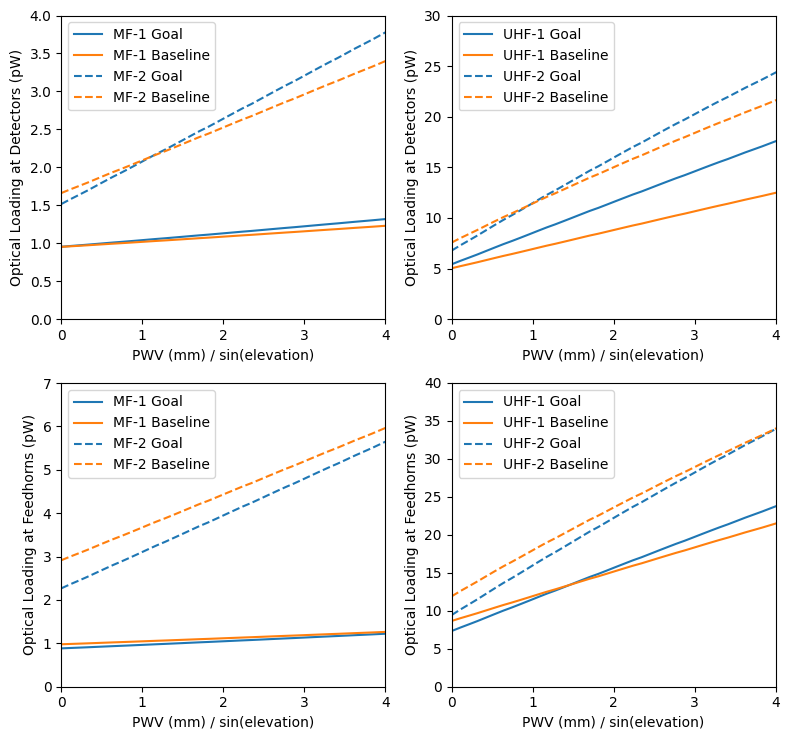

In [8]:
fig = plt.figure(figsize=(8,7.5))
plt.subplot(2,2,1)
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_detectors['goal']['MF']['MF_1'], label='MF-1 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_detectors['baseline']['MF']['MF_1'], label='MF-1 Baseline')

plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_detectors['goal']['MF']['MF_2'], 'C0--', label='MF-2 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_detectors['baseline']['MF']['MF_2'], 'C1--', label='MF-2 Baseline')

plt.legend()
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("PWV (mm) / sin(elevation)")
plt.ylabel("Optical Loading at Detectors (pW)")

plt.subplot(2,2,2)
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_detectors['goal']['UHF']['UHF_1'], label='UHF-1 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_detectors['baseline']['UHF']['UHF_1'], label='UHF-1 Baseline')

plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_detectors['goal']['UHF']['UHF_2'], 'C0--', label='UHF-2 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_detectors['baseline']['UHF']['UHF_2'], 'C1--', label='UHF-2 Baseline')

plt.legend()
plt.ylim(0,30)
plt.xlim(0,4)
plt.xlabel("PWV (mm) / sin(elevation)")
plt.ylabel("Optical Loading at Detectors (pW)")

plt.subplot(2,2,3)
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_feedhorns['goal']['MF']['MF_1'], label='MF-1 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_feedhorns['baseline']['MF']['MF_1'], label='MF-1 Baseline')

plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_feedhorns['goal']['MF']['MF_2'], 'C0--', label='MF-2 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_feedhorns['baseline']['MF']['MF_2'], 'C1--', label='MF-2 Baseline')

plt.legend()
plt.ylim(0,7)
plt.xlim(0,4)
plt.xlabel("PWV (mm) / sin(elevation)")
plt.ylabel("Optical Loading at Feedhorns (pW)")

plt.subplot(2,2,4)
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_feedhorns['goal']['UHF']['UHF_1'], label='UHF-1 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_feedhorns['baseline']['UHF']['UHF_1'], label='UHF-1 Baseline')

plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_feedhorns['goal']['UHF']['UHF_2'], 'C0--', label='UHF-2 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e12*optical_loading_feedhorns['baseline']['UHF']['UHF_2'], 'C1--', label='UHF-2 Baseline')

plt.legend()
plt.ylim(0,40)
plt.xlim(0,4)
plt.xlabel("PWV (mm) / sin(elevation)")
plt.ylabel("Optical Loading at Feedhorns (pW)")

fig.tight_layout()
#plt.savefig("detector_optical_loading.png")

In [9]:
optical_loading_detectors["pwv_sin_el"] = pwv_list/np.sin(np.radians(elevation))

with open("opt_load_det.pk", "wb") as f:
    pk.dump(optical_loading_detectors, f)

# NETs

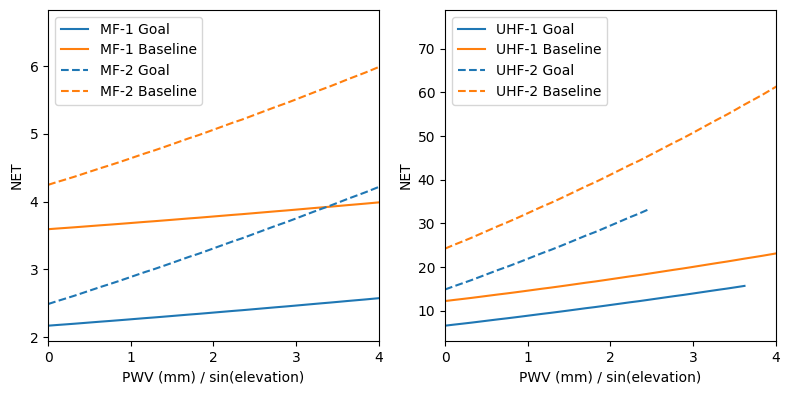

In [10]:
fig = plt.figure(figsize=(8,7.5))
plt.subplot(2,2,1)
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e6*wafer_net_nc['goal']['MF']['MF_1']/np.sqrt(12), label='MF-1 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e6*wafer_net_nc['baseline']['MF']['MF_1']/np.sqrt(12), label='MF-1 Baseline')

plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e6*wafer_net_nc['goal']['MF']['MF_2']/np.sqrt(12), 'C0--', label='MF-2 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e6*wafer_net_nc['baseline']['MF']['MF_2']/np.sqrt(12), 'C1--', label='MF-2 Baseline')

plt.legend()
#plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("PWV (mm) / sin(elevation)")
plt.ylabel("NET")

plt.subplot(2,2,2)
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e6*wafer_net_nc['goal']['UHF']['UHF_1']/np.sqrt(6), label='UHF-1 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e6*wafer_net_nc['baseline']['UHF']['UHF_1']/np.sqrt(6), label='UHF-1 Baseline')

plt.plot( pwv_list/np.sin(np.radians(elevation)),  1e6*wafer_net_nc['goal']['UHF']['UHF_2']/np.sqrt(6), 'C0--', label='UHF-2 Goal')
plt.plot( pwv_list/np.sin(np.radians(elevation)), 1e6*wafer_net_nc['baseline']['UHF']['UHF_2']/np.sqrt(6), 'C1--', label='UHF-2 Baseline')

plt.legend()
#plt.ylim(0,30)
plt.xlim(0,4)
plt.xlabel("PWV (mm) / sin(elevation)")
plt.ylabel("NET")


fig.tight_layout()
#plt.savefig("detector_optical_loading.png")

In [11]:
wafer_net_c["pwv_sin_el"] = pwv_list/np.sin(np.radians(elevation))

with open("wafer_net_c.pk", "wb") as f:
    pk.dump(wafer_net_c, f)

In [12]:
elevation_list = np.arange(20, 70, 5)
pwv_list = np.linspace(0,4,20)

el, pwv = np.meshgrid( elevation_list, pwv_list)
atmosphere_eff = {}
dict_list = [atmosphere_eff]

## initialize the dictionaries
for kind in sim_list:
    for my_dict in dict_list:
        my_dict[kind] = {}
    for flavor in sim_list[kind]:
        for my_dict in dict_list:
            my_dict[kind][flavor] = {}       
        sim = load_sim(sim_list[kind][flavor])
        for ch in sim['channels']:
            for my_dict in dict_list:
                my_dict[kind][flavor][ch] = np.zeros_like(pwv)


for kind in sim_list:
    print(kind)
    for flavor in sim_list[kind]:
        for i in range(pwv.shape[0]):
            for j in range(pwv.shape[1]):
                sim = load_sim(sim_list[kind][flavor])
                
                sim['sources']['atmosphere']['elevation'] = el[i,j]
                sim['sources']['atmosphere']['pwv'] = int(1000*pwv[i,j])
                jf.run_optics(sim)
                jf.run_bolos(sim)
                
                for ch in sim['channels']:
                    atmosphere_eff[kind][flavor][ch][i,j] = sim['outputs'][ch]['sources']['atmosphere']['effic_avg']

baseline
goal


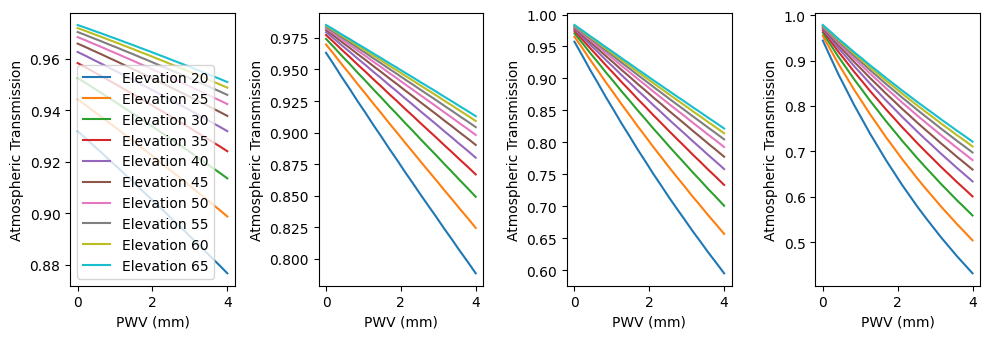

In [13]:
fig = plt.figure(figsize=(10,3.5))

el_colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
kind_styles = {'baseline':'-', 'goal':'--'}
## baseline and goal (currently) have the same bandpasses. 
## So the atmospheric efficiency calculation are the same for both
kind = 'baseline' 

for f, flavor in enumerate(['MF', 'UHF']):
    for c, ch in enumerate(atmosphere_eff[kind][flavor]):
        plt.subplot(1,4,2*f+c+1)

        for i in range(pwv.shape[1]):
            plt.plot( pwv[:,i], atmosphere_eff[kind][flavor][ch][:,i], color=el_colors[i], ls=kind_styles[kind], label=f'Elevation {el[0,i]}')

        plt.xlabel("PWV (mm)")
        plt.ylabel("Atmospheric Transmission")
        
plt.subplot(1,4,1)
plt.legend()
fig.tight_layout()

In [14]:
atmosphere_eff["pwv"] = pwv[...,0]

In [15]:
test = {}
test["pwv"] = pwv[...,0]
for ufm_key in atmosphere_eff["baseline"].keys():
    test[ufm_key] = {}
    for ufm_flavor in atmosphere_eff["baseline"][ufm_key].keys():
        test[ufm_key][ufm_flavor] = {}
        for i, el in enumerate(elevation_list):
            test[ufm_key][ufm_flavor][str(el)] = atmosphere_eff["baseline"][ufm_key][ufm_flavor][...,i]

In [16]:
test.keys()

dict_keys(['pwv', 'LF', 'MF', 'UHF'])

In [17]:
with open("./atmosphere_eff.pk", "wb") as f:
    pk.dump(test, f)

In [18]:
atmosphere_eff["baseline"]["LF"]["LF_1"].shape

(20, 10)

In [19]:
len(elevation_list)

10

In [ ]:
atmosphere_eff["baseline"]["MF"]["MF_1"][...,0]